# Gentrification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import sys
import rtree
import warnings

warnings.filterwarnings('ignore')
sys.path.append('../')

from src.d00_utils.file_paths import SF_GENT_PATH, REDLINING_PATH
from src.d01_data.block_data_api import BlockDataApi
from src.d01_data.student_data_api import StudentDataApi, _block_features, _census_block_column
from src.d04_modeling import propositional_classifier as pc
from src.d06_reporting.Gentrification import Gentrification

SF_gent = pd.read_csv(SF_GENT_PATH)
redlining = gpd.read_file(REDLINING_PATH)
block_data_api = BlockDataApi()
block_df_dict = block_data_api.get_data(sfha=False).set_index('Block')
gentrification = Gentrification()
frl_df_raw = block_data_api.get_data(frl=True)

### Background & Context

We wanted to understand the impact that gentrification could have on demographics within the SFUSD district, and how that would impact the equity tiebreaker. Gentrification can be understood as the process by which "central urban neighborhoods have undergone disinvestments and economic decline experience a reversal, reinvestment, and in-migration of a relatively well-off middle and upper middle-class population" [(Gentrification and Academic Achievement, 128)](https://journals.sagepub.com/doi/10.3102/0034654318805924).

Essentially, gentrification causes predominantly wealthy, white families and individuals to move into low-income, predominantly minority and historically marginalized neighborhoods. Gentrification has been seen to have *positive impacts*: gentrifying individuals bring **greater resources and social/political/economic capital** that can benefit the district as a whole. However, gentrification also has distinctly *negative impacts*: it can raise the cost of living, displacing former residents and families. Additionally, the capital and social power of gentrifying families can be used to only benefit themselves while amplifying existing inequalities in resources and opportunities for the former residents [Unpacking the Relationship Between Gentrification and Urban Schooling](https://www.taylorfrancis.com/chapters/edit/10.4324/9780429331435-37/unpacking-relationship-gentrification-urban-schooling-francis-pearman). 

Most directly, we want to be aware of the fact that gentrification changes the racial and economic demographics of neighborhoods and areas. Thus, we want to make sure that we do not give equity tiebreakers to areas that have already been gentrified, as the majority of residents are likely non-focal. Additionally, we need to monitor areas that may be gentrified, as the gentrifying individuals rather than focal students might benefit from the block being classified as a target block by the tiebreaker. 

### Gentrification EDA

To learn more about Gentrification and how it impacts our equity tiebreaker/educational outcomes, we conducted some **Exploratory Data Analysis (EDA)**. We used data from the [Urban Displacement Project](https://github.com/urban-displacement/displacement-typologies) at UC Berkeley. UDP leverages data from the 2013-2018 American Community Survey, 1990,2000, and 2010 Decennial Census, and 2012-2017 Zillow Home Value and Rent Indicies to create a typology of displacement and gentrification. Attached is a shorthand for the gentrification statuses (increasing in the severity of displacement): 

* OD: Ongoing Displacement of Low-Income Neighborhoods
* ARG: At Risk of Gentrification
* EOG: Early/Ongoing Gentrification 
* AdvG: Advanced Gentrification 
* SMMI: Stable Moderate/Mixed Income
* ARE: At Risk of Becoming Exclusive
* BE: Becoming Exclusive 
* SAE: Stable/Advanced Exclusive 

Our first visualization is creating a heatmap of gentrification statuses vs. CTIP 2013 assignments for tracts in SFUSD to understand the relationship between the two. 

You can see that as gentrification statuses increase, the CTIP scores are more concentrated in the higher quintiles. There is almost a diagonal going from CTIP1 to SAE, illustrating the positive relationship between gentrification and CTIP status.

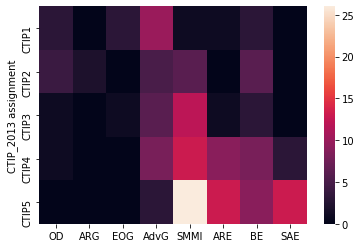

In [2]:
ax = gentrification.gentrification_data(SF_gent, block_df_dict)
plt.show()

This visualization shows a heatmap of student demographic information (FRL, AALPI, Combo: Both FRL and AALPI, and Other students) in comparison to CTIP assignment. These demographics counts are averaged over 4 years in each census tract. Each cell shows the percentage of demographic students in each CTIP region. For example, the cell in the first row and column illustrates that ~0.6, or *60% of FRL and AALPI students in SFUSD (averaged over 4 years) lived in CTIP1 regions*.

We can see that for CTIP1 tracts, the majority of students are FRL and AALPI students. As CTIP scores increase, the density of focal students in each column decreases. In contrast, as CTIP scores increase, the density of "other" students increases. 

This graphic illustrates that CTIP served as a semi-valid proxy for demographic categories like FRL and AALPI students. 

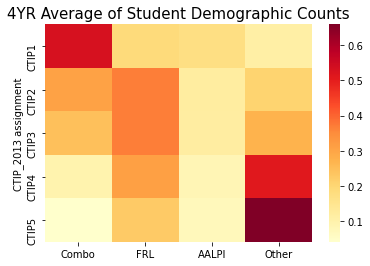

In [3]:
ax = gentrification.frl_vs_ctip(frl_df_raw, block_df_dict)
plt.show()

Now, we have a grouped barchart to illustrate the distribution of demographic counts across gentrification typologies. Each gentrification status has a corresponding bar for 4YR AVG FRL, AALPI (Eth Flag), and FRL+AALPI students (Combo Flag). We can see that the majority of students in each gentrification status are FRL, followed by AALPI and then FRL+AALPI students.  

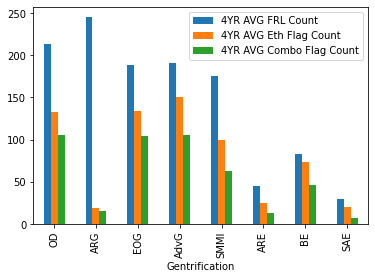

In [4]:
ax = gentrification.grouped_barchart(frl_df_raw, SF_gent)[0]
plt.show()

Lastly, we created a stacked barchart to illustrate the breakdown of demographic (focal) students within each gentrification category. The areas we suggest the tiebreaker targets are those on the lower end of the spectrum, from Ongoing Displacement (OD) to Early/Ongoing Gentrification (EOG). Those categories have meaningful distributions or breakdowns of focal students within them

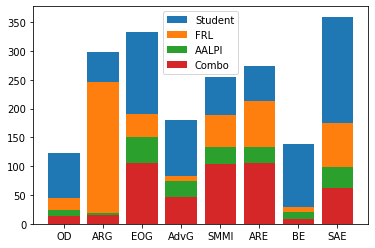

In [5]:
ax = gentrification.stacked_barchart(frl_df_raw, SF_gent)
plt.show()

### Gentrification Maps

Now, let's work to create a map illustrating the gentrification status of each GEOID10 blockgroup. First, we will load our ```grouped_Geoid``` dataset, which shows the 4YR Average Demographic Counts + Gentrification Status for each corresponding GEOID10 Blockgroup.

In [6]:
grouped_Geoid = gentrification.grouped_Geoid(frl_df_raw, SF_gent)
grouped_Geoid.head(5)

,4YR AVG Student Count,4YR AVG FRL Count,4YR AVG Eth Flag Count,4YR AVG Combo Flag Count,Gentrification,New Gent
GEOID,,,,,,
6075010300,93.50,30.50,6.50,3.00,ARE,6
6075010400,122.75,50.75,13.75,2.25,ARE,6
6075010500,89.00,63.75,8.25,7.00,ARE,6
6075010700,422.25,344.50,25.75,21.00,OD,1
6075010800,154.25,105.25,6.75,3.75,BE,7


Now, we will plot the gentrification map mentioned above. Our function takes in an ```eligibility_classifier``` and ```final_classifier``` as parameters, as well as the ```params``` input. These inputs can be changed and altered. 

The legend at the bottom illustrates that as the colors shift from yellower to redder and stronger, the gentrification/displacement status increases. In other words, an area colored "1" corresponds to Ongoing Displacement and is at the lowest end of the gentrification spectrum. An area corresponding to "8" is categorized as "Stable Advanced Exclusive" and is at the highest end of the gentrification spectrum. Areas shaded in gray correspond to the missing values we do not have. 

Loading Block FRL data...Adding African-American counts to FRL data...
0.8401
Loading Block Demographic data...0.1861
Loading Student Demographic data...2.0079


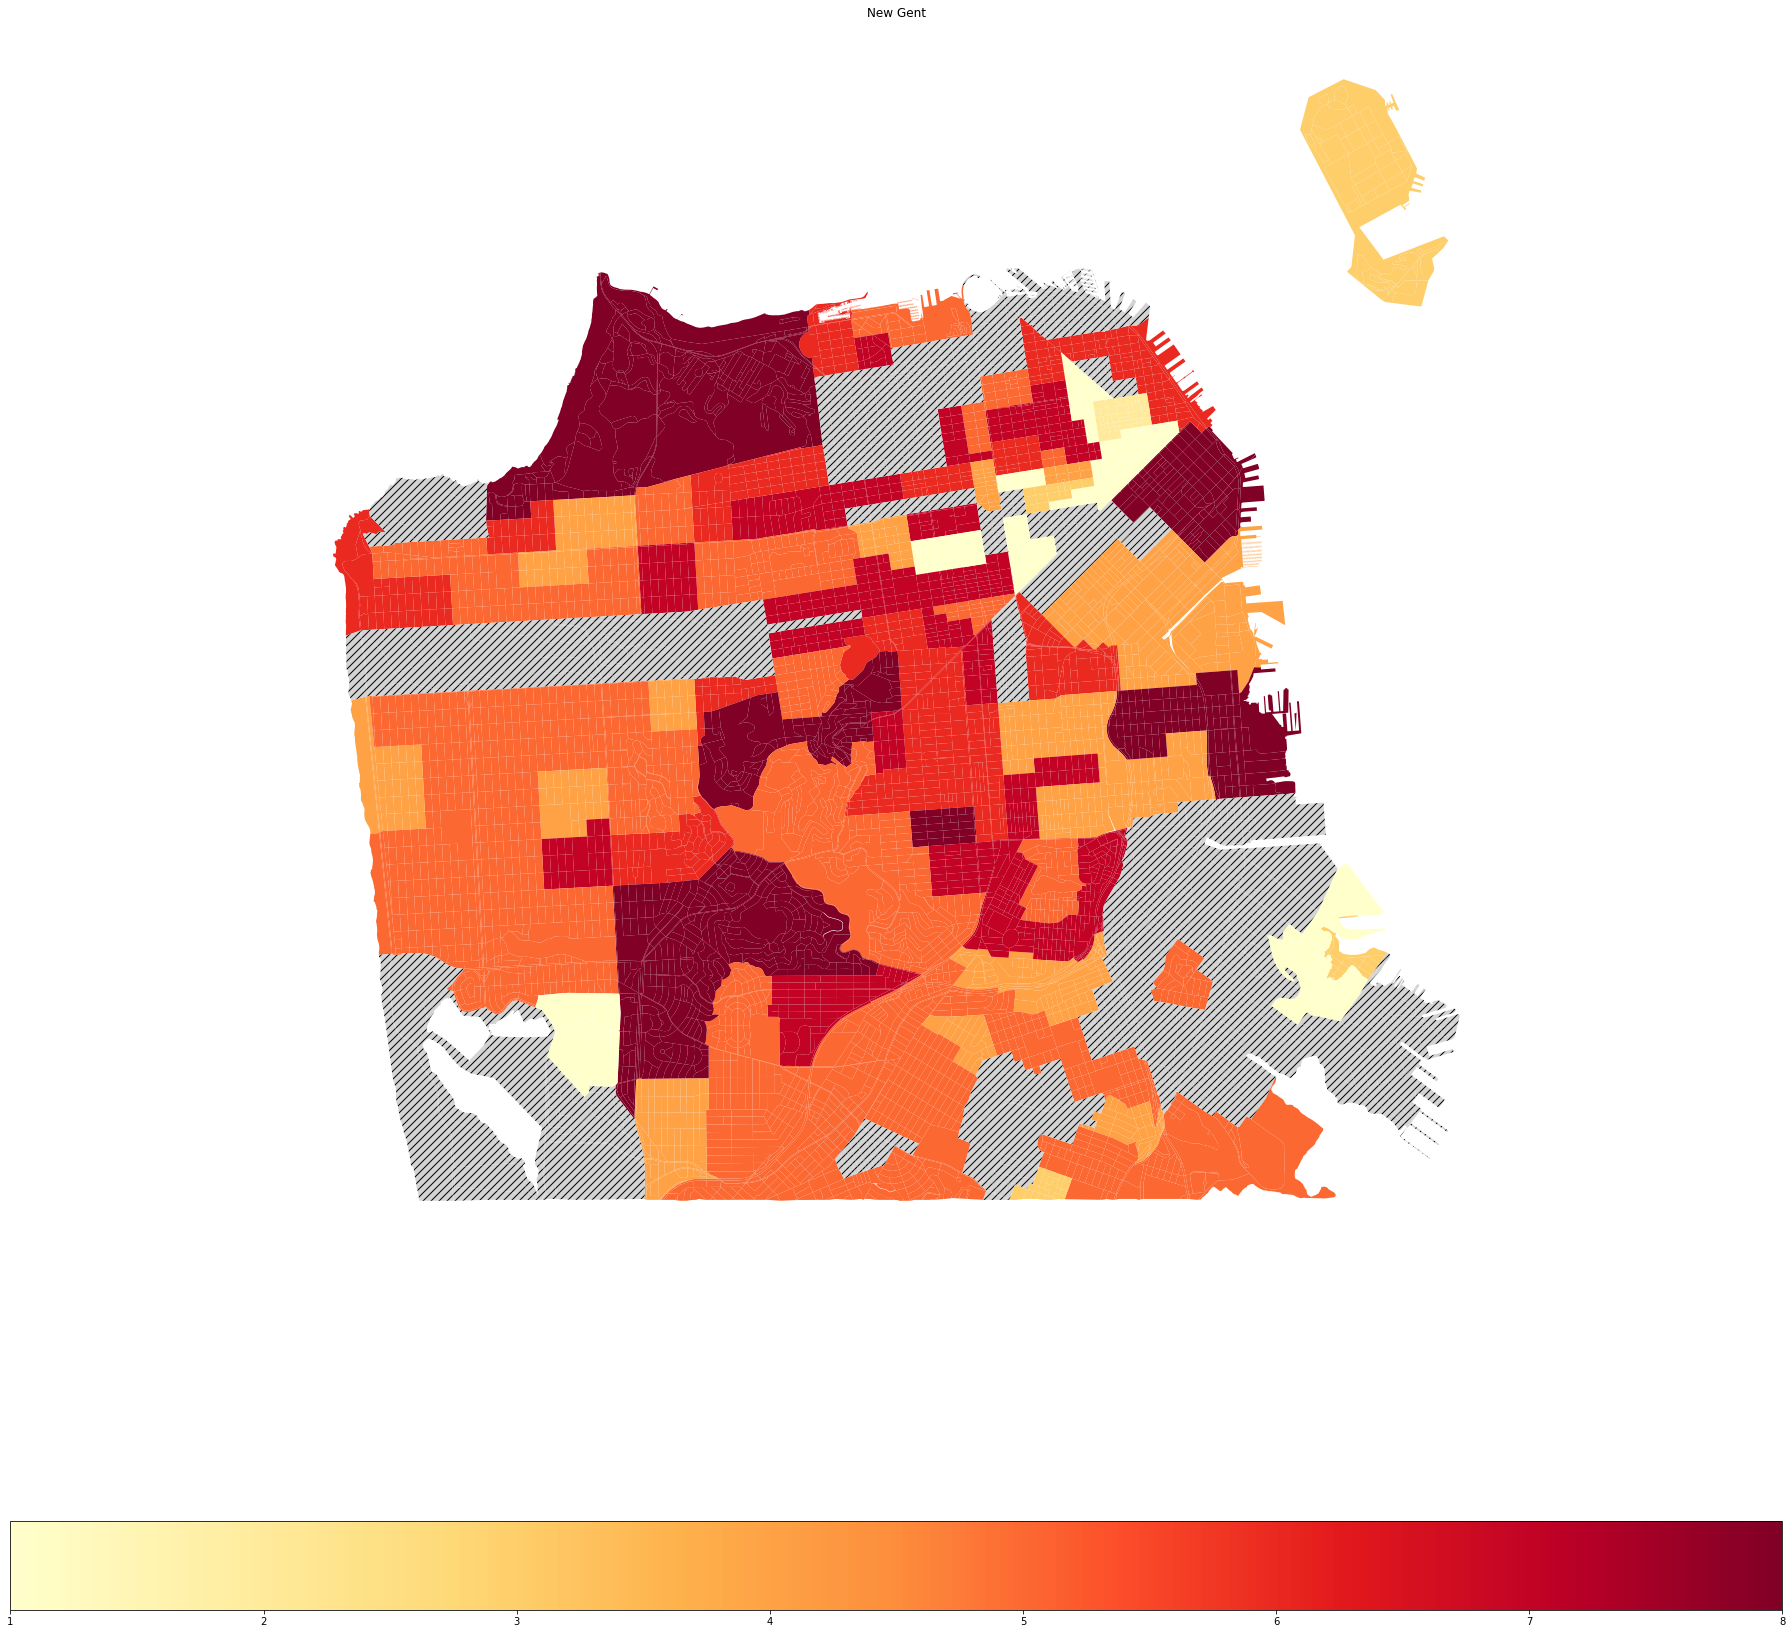

In [7]:
eligibility_classifier = pc.orClassifier(["Housing", "Redline"], binary_var=[0,1])
final_classifier = pc.andClassifier(["pctBoth"], positive_group="nBoth", eligibility_classifier=eligibility_classifier)
params = 0.4
ax = gentrification.gentrification_map(eligibility_classifier, final_classifier, params, grouped_Geoid)
plt.show()

To see where the equity tiebreakers designed under our current classifier exist, we can overlay them with our existing map! Our hope is that the tiebreakers are **awarded** to areas that are yellowish, or lower on the gentrification scale. This means that those areas are at risk of gentrification or undergoing displacement, and could thus benefit directly from the equity tiebreaker. 

We hope to **monitor** areas marked in orange -- in the middle of the process of gentrification and displacement. This is due to a belief that the demographics of those areas may change and become more socio-economically and racially exclusive. Consequently, they may not merit the equity tiebreaker; if those blocks are awarded one, we would potentially increase the number of "false positives". 

Lastly, we want to **avoid** giving tiebreakers to areas marked as red. Those areas are highly exclusive due to gentrification that has already occured. As a result, residents tend to be predominantly wealthy and white, and likely not considered focal students. 

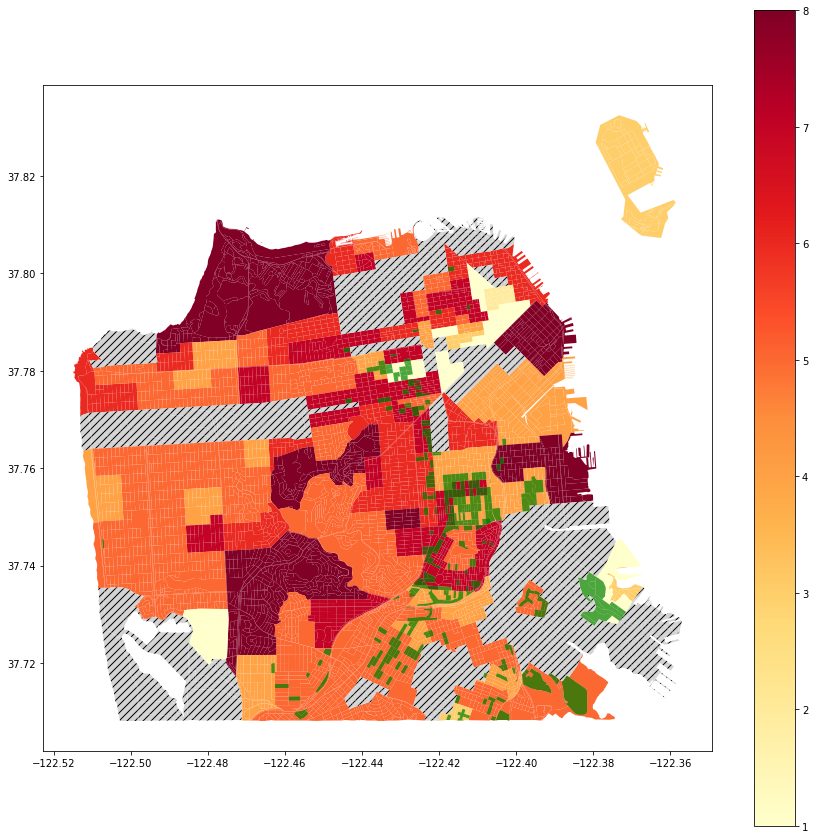

In [8]:
ax = gentrification.gentrification_map_tiebreaker(final_classifier)
plt.show()